In [33]:
import torch
import torch.nn as nn

import numpy as np
import copy

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [3]:
from sine_data_generator import SineDataGenerator

In [ ]:
data_gen = SineDataGenerator(10, 16)

inputs_np, outputs_np, amp_np, phase_np = data = data_gen.generate()
inputs, outputs, amp, phase = [torch.Tensor(arr) for arr in data]

In [5]:
inputs.shape, outputs.shape, amp.shape, phase.shape

(torch.Size([16, 10, 1]),
 torch.Size([16, 10, 1]),
 torch.Size([16]),
 torch.Size([16]))

### Modules

In [ ]:
def relu_seq(sizes):
    layers = []
    d_input = sizes[0]

    for d_hidden in sizes[1:-1]:
        layers.append(nn.Linear(d_input, d_hidden))
        layers.append(nn.ReLU())
        d_input = d_hidden

    d_output = sizes[-1]
    layers.append(nn.Linear(d_input, d_output))  # output layer
    return layers


# TODO add dropout

class ReluNet(nn.Module):
    def __init__(self, *sizes):
        super().__init__()
        layers = relu_seq(sizes)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


#### Encoder

In [ ]:
import torch
import torch.nn as nn

class IOPairSetEncoder(nn.Module):
    """DeepSet encoder for input-output pairs (N per batch)"""
    def __init__(self,
                 phi=ReluNet(2, 32, 32),
                 rho_0=ReluNet(32, 32, 16),
                 rho_1=ReluNet(16, 8, 3)):
        super().__init__()
        # Shared encoder phi
        self.phi = phi
        # Output processor rho
        self.rho_0 = rho_0
        self.rho_1 = rho_1
        self.rho_2 = copy.deepcopy(rho_1)

    def forward(self, x):
        # x: (batch_size, N, 2)
        x_phi = self.phi(x)                 # (batch_size, N, hidden_dim)
        x_sum = x_phi.sum(dim=1)            # (batch_size, hidden_dim)
        common = self.rho_0(x_sum)            # (batch_size, hidden_dim)
        mu = self.rho_1(common)               # (batch_size, output_dim)
        logvar = self(common)
        return mu, logvar


In [8]:
io_pairs = torch.cat([inputs, outputs], dim=-1)  # (batch_size, N, 2)
io_pairs.shape

torch.Size([16, 10, 2])

In [9]:
set_encoder = IOPairSetEncoder()
z = set_encoder(io_pairs)
z.shape  # (batch_size, output_dim)

torch.Size([16, 3])

In [10]:
set_encoder

IOPairSetEncoder(
  (phi): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (rho): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=3, bias=True)
    )
  )
)

#### Decoder

In [ ]:
class Decoder(ReluNet):
    # TODO add a batchnorm

    def __init__(self, d_input=1, d_latent=3, ds_hidden=[32, 32], d_output=1):
        sizes = [d_latent + d_input] + ds_hidden + [d_output]
        super().__init__(*sizes)
        self.d_input = d_input
        self.d_latent = d_latent
        self.d_output = d_output


In [12]:
z.shape, inputs.shape

(torch.Size([16, 3]), torch.Size([16, 10, 1]))

In [13]:
input_0 = inputs[:, 0, :]  # (batch_size, d_input)
input_0.shape

torch.Size([16, 1])

In [14]:
z_expanded = z.unsqueeze(1).expand(-1, inputs.size(1), -1)
z_inputs = torch.cat([z_expanded, inputs], axis=-1)
z_inputs.shape

torch.Size([16, 10, 4])

In [15]:
decoder = Decoder()
decoder

Decoder(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [16]:
decoder(z_inputs).shape

torch.Size([16, 10, 1])

### Utils

In [34]:
def make_leave_one_out(array: torch.Tensor, axis: int) -> torch.Tensor:
    """
    Args:
        array: Tensor of shape (*B, N, *H).
        axis: The axis where N appears.

    Returns:
        Tensor of shape (*B, N, N-1, *H).
    """
    axis = axis % array.ndim
    n = array.size(axis)
    output = []

    for i in range(n):
        array_before = array.narrow(axis, 0, i)
        array_after = array.narrow(axis, i + 1, n - i - 1)
        sliced = torch.cat([array_before, array_after], dim=axis)
        output.append(sliced)

    output = torch.stack(output, dim=axis)
    return output

In [35]:
# Create a random tensor
random_array = torch.randn(4, 5, 6)  # Example shape (4, 5, 6)

# Apply the make_leave_one_out function
leave_one_out_result = make_leave_one_out(random_array, axis=1)

# Print the shapes to verify
print("Original shape:", random_array.shape)
print("Leave-one-out shape:", leave_one_out_result.shape)

Original shape: torch.Size([4, 5, 6])
Leave-one-out shape: torch.Size([4, 5, 4, 6])


In [38]:
random_array[0, :, :]

tensor([[-1.2035,  0.7266,  0.9145, -0.0743, -0.1955,  1.3383],
        [ 0.1514,  0.4020,  0.2766,  0.5511,  0.1775, -0.0041],
        [ 0.8557, -0.1617,  0.7642,  1.0259,  0.7809, -1.2670],
        [-0.2485,  0.2778, -2.4740,  0.0849, -0.2568,  1.4575],
        [ 0.0082, -0.4130,  0.6050, -0.7613, -0.5642,  0.2237]])

In [36]:
leave_one_out_result[0, 0, :, :]

tensor([[ 0.1514,  0.4020,  0.2766,  0.5511,  0.1775, -0.0041],
        [ 0.8557, -0.1617,  0.7642,  1.0259,  0.7809, -1.2670],
        [-0.2485,  0.2778, -2.4740,  0.0849, -0.2568,  1.4575],
        [ 0.0082, -0.4130,  0.6050, -0.7613, -0.5642,  0.2237]])

### [WIP] LPN

In [ ]:
class LPN(nn.Module):
    def __init__(self,
                 d_input,
                 d_output,
                 d_latent,
                 encoder
                 decoder):
        super().__init__()
        self.d_input = d_input
        self.d_output = d_output
        self.d_latent = d_latent
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, pairs):
        # pairs: (batch_size, N, d_input, 2)
        # Note: assuming d_input = d_output
        # pairs_leave_one_out: (batch_size, N, N-1, d_input, 2)
        pairs_leave_one_out = make_leave_one_out(pairs, axis=1)

        # Encoder
        # z_mu, z_logvar: (batch_size, N, d_latent)
        z_mu, z_logvar = self.encoder(pairs_leave_one_out)

        assert z_mu.shape == z_logvar.shape
        assert z_mu.shape == (pairs.size(0), pairs.size(1), self.d_latent)

        

        

### [WIP] Algorithm 1: LPN Test-Time Inference w. GA Latent Opt

In [ ]:
# Input
data_gen = SineDataGenerator(10, 16)
inputs, outputs, amp, phase = [torch.Tensor(arr) for arr in data_gen.generate()]
# Context: n=10 input-output pairs (x_i, y_i)
ctx_inputs = inputs[:, :-1, :]
ctx_outputs = outputs[:, :-1, :]
# Test input x_{n+1}
test_inputs = inputs[:, -1, :].unsqueeze(1)
test_outputs = outputs[:, -1, :].unsqueeze(1)
# number of gradient steps
K = 7
D_LATENT = 3
alpha = 0.1

In [22]:
ctx_inputs.shape, ctx_outputs.shape, test_inputs.shape, test_outputs.shape

(torch.Size([16, 9, 1]),
 torch.Size([16, 9, 1]),
 torch.Size([16, 1, 1]),
 torch.Size([16, 1, 1]))

In [26]:
# Init encoder-decoder
encoder = IOPairSetEncoder(phi=ReluNet(2, 32, 32), rho=ReluNet(32, 32, D_LATENT))
decoder = Decoder(d_input=1, d_latent=D_LATENT, ds_hidden=[32, 32], d_output=1)

In [32]:
io_pairs = torch.cat([ctx_inputs, ctx_outputs], dim=-1)  # (batch_size, N, 2)
z_prime = z_prime_0 = encoder(io_pairs)
z_prime_0.shape  # (batch_size, d_latent)

torch.Size([16, 3])

In [ ]:
# for k in range(K):
#     z_prime += alpha * 

In [28]:
encoder

IOPairSetEncoder(
  (phi): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (rho): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=3, bias=True)
    )
  )
)

In [30]:
ctx_inputs.shape

torch.Size([16, 9, 1])

### Plotting

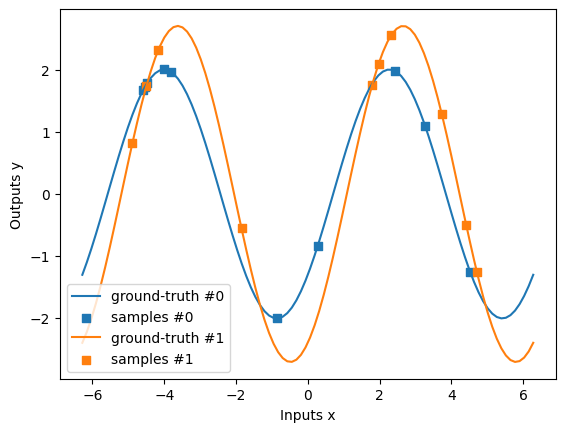

In [18]:
import matplotlib.pyplot as plt

# Plot each set of inputs and outputs as a separate line
for i in range(min(2, inputs_np.shape[0])):
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    y = amp_np[i] * np.sin(x - phase_np[i])
    plt.plot(x, y, label=f"ground-truth #{i}")
    plt.scatter(inputs_np[i], outputs_np[i], marker='s', label=f"samples #{i}")
    # plt.plot(init_inputs[i], outputs[i], label=f"Line {i+1}")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
# plt.title("Outputs vs Inputs")
plt.legend()
plt.show()